In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from gurobipy import *
from matplotlib import pyplot as plt
import collections
from copy import *
from IPython.display import HTML
from IPython.display import display
from collections import *

In [2]:
# 'skus' table
skus = pd.read_csv('JD_sku_data.csv')
# 'orders' table
orders = pd.read_csv('JD_order_data.csv')
# 'delivery' table
delivery = pd.read_csv('JD_delivery_data.csv')
# 'inventory' table
inventory = pd.read_csv('JD_inventory_data.csv')
# 'network' table
network = pd.read_csv('JD_network_data.csv')

# Data Processing

We consider one region as instance

In [3]:
sample_dcs = sorted(network[network['region_ID'] == 3]['dc_ID'].tolist())
sample_dcs

[3, 14, 33, 34, 35, 64]

In [4]:
orders_in_sample_dcs = orders[(orders['dc_des'].isin(sample_dcs)) & (orders['order_date'] <= '2018-03-31') & (orders['gift_item'] == 0)]
len(orders_in_sample_dcs)

27493

In [5]:
skus_in_sample_dcs = orders_in_sample_dcs.groupby('sku_ID').count()['order_ID'].to_dict()
len(skus_in_sample_dcs)

2548

We choose top SKUs 

In [50]:
demand_over_skus = orders_in_sample_dcs.groupby('sku_ID').count()['order_ID'].to_dict()
sample_skus = [i for i, j in sorted(demand_over_skus.items(), key = lambda kv: kv[1], reverse=True)]

sample_skus = sample_skus[:100]
sample_orders = orders_in_sample_dcs[orders_in_sample_dcs['sku_ID'].isin(sample_skus)]

In [51]:
sample_orders.to_csv("sample_orders_top100.csv")

In [64]:
demand_over_skus = sample_orders.groupby('sku_ID').count()['order_ID'].to_dict()
demand_over_dcs = sample_orders.groupby('dc_des').count()['order_ID'].to_dict()
supply_over_dcs = sample_orders.groupby('dc_ori').count()['order_ID'].to_dict()

#sample_skus = [i for i, j in sorted(demand_over_skus.items(), key = lambda kv: kv[1], reverse=True)]

In [67]:
supply_share_mean = [supply_over_dcs[i] / sum(supply_over_dcs.values()) for i in sample_dcs]
supply_share_mean

[0.2754117344312918,
 0.008299022130725682,
 0.1405043746783325,
 0.07707153885743695,
 0.06632784354091611,
 0.05603448275862069]

In [53]:
demand_over_skus_dcs = {}
for i in sample_dcs:
    sample_orders_dc = sample_orders[sample_orders['dc_des'] == i]
    tmp = sample_orders_dc.groupby('sku_ID').count()['order_ID'].to_dict()
    demand_over_skus_dcs[i] = tmp

In [54]:
market_share_dcs = []
for i in sample_dcs:
    tmp = []
    for k in sample_skus:
        if k in demand_over_skus_dcs[i]:
            tmp.append(demand_over_skus_dcs[i][k] / demand_over_dcs[i])
        else:
            tmp.append(0)
    market_share_dcs.append(tmp)
    
market_share_skus = []
for k in sample_skus:
    tmp = []
    for i in sample_dcs:
        if k in demand_over_skus_dcs[i]:
            tmp.append(demand_over_skus_dcs[i][k] / demand_over_dcs[i])
        else:
            tmp.append(0)
    market_share_skus.append(tmp)

In [56]:
market_share_mean = np.array(sorted(demand_over_skus.values(), reverse=True)) / sum(demand_over_skus.values())

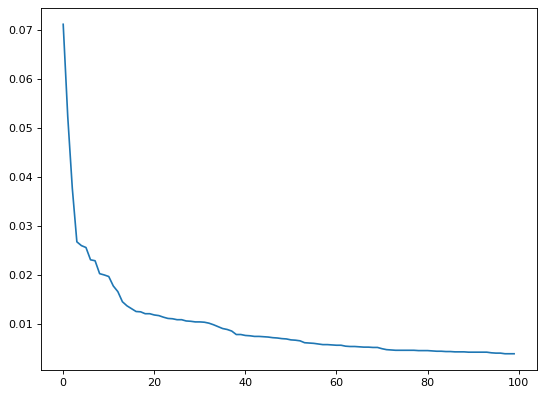

In [77]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(100), market_share_mean)

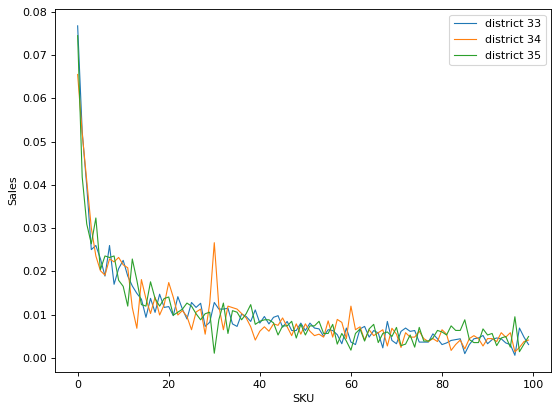

In [79]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(np.arange(100), market_share_dcs[2], lw=1, label="district 33")
plt.plot(np.arange(100), market_share_dcs[3], lw=1, label="district 34")
plt.plot(np.arange(100), market_share_dcs[4], lw=1, label="district 35")
plt.xlabel("SKU")
plt.ylabel("Sales")
plt.legend()

In [57]:
np.mean(np.std(np.array(market_share_skus), axis=1) / market_share_mean)

0.40928357776831736

In [58]:
price_over_skus = sample_orders.groupby('sku_ID').mean()['original_unit_price'].to_dict()

In [90]:
np.mean(list(price_over_skus.values())) * 0.2

20.69686079191923

In [93]:
price_over_skus['068f4481b3']

297.2682926829268

(array([ 1.,  2.,  0.,  3.,  1.,  2.,  8., 15., 20.,  7.,  3.,  6.,  3.,
         4.,  1.,  2.,  4.,  5.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,
         1.]),
 array([ 12.        ,  19.71923077,  27.43846154,  35.15769231,
         42.87692308,  50.59615385,  58.31538462,  66.03461538,
         73.75384615,  81.47307692,  89.19230769,  96.91153846,
        104.63076923, 112.35      , 120.06923077, 127.78846154,
        135.50769231, 143.22692308, 150.94615385, 158.66538462,
        166.38461538, 174.10384615, 181.82307692, 189.54230769,
        197.26153846, 204.98076923, 212.7       , 220.41923077,
        228.13846154, 235.85769231, 243.57692308, 251.29615385,
        259.01538462, 266.73461538, 274.45384615, 282.17307692,
        289.89230769, 297.61153846, 305.33076923, 313.05      ,
        320.76923077]),
 <BarContainer object of 40 artists>)

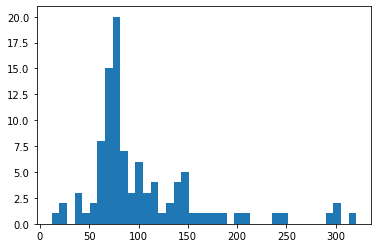

In [61]:
plt.hist(price_over_skus.values(), bins=40)

We generate demand scenarios

In [9]:
demand_dist = {}
for i in sample_dcs:
    for k in sample_skus:
        hist = []
        for d in range(1, 32):
            if d <= 9:
                date = '2018-03-0' + str(d)
            else:
                date = '2018-03-' + str(d)
            hist.append(len(sample_orders[(sample_orders['dc_des'] == i) & (sample_orders['sku_ID'] == k) & (sample_orders['order_date'] == date)]))
            
        demand_dist[i, k] = (np.mean(hist), np.std(hist))

In [10]:
total_demand = sum(demand_over_skus.values()) 
T = int((np.ceil(total_demand / 1000)) * 1000) 
sku_freq = []
for k in sample_skus:
    if k in demand_over_skus:
        sku_freq.append(demand_over_skus[k] / T)
    else:
        sku_freq.append(0)
dc_freq = [demand_over_dcs[dc] / total_demand for dc in sample_dcs]
multinomial_sku = [1 - sum(sku_freq)] + sku_freq
multinomial_dc = dc_freq

In [11]:
N = 1000
demand_scenarios = []
demand_scenarios_agg = []

for n in range(N):
    skus = np.random.choice(['NA'] + sample_skus, T, p=multinomial_sku)
    dcs = np.random.choice(sample_dcs, T, p=multinomial_dc)
    sample = list(zip(skus, dcs))
        
    demand_scenarios.append(sample)

#     D = {}
#     for i in sample_dcs:
#         for k in sample_skus:
#             D[k, i] = max(int(sum(np.random.normal(demand_dist[i, k][0], demand_dist[i, k][1], 7))), 0)
#     demand_scenarios_agg.append(D)

expected = {}
for k in range(len(sku_freq)):
    for i in range(len(dc_freq)):
        expected[sample_skus[k], sample_dcs[i]] = T * sku_freq[k] * dc_freq[i]    

## Model Formulation

In [17]:
def optimize(S, D): 
    model = Model('model')
    model.setParam("LogToConsole", 0)

    fulfill = model.addVars(((k, i, j) for k in sample_skus for i in supply for j in demand), vtype=GRB.CONTINUOUS, name='fulfill')

    model.setObjective(sum(fulfill[k, i, j] * cost[k, i, j] for k, i, j in fulfill), GRB.MINIMIZE)

    for k in sample_skus:
        for i in supply:
            model.addConstr(fulfill.sum(k, i, '*') <= S[k, i], name='supply_%s_%s' % (k, i))

        for j in demand:
            model.addConstr(fulfill.sum(k, '*', j) == D[k, j], name='demand_%s_%s' % (k, j))

    model.optimize()
    
    return model, fulfill

def optimize_k(k, S, D): 
    model = Model('model_1')
    model.setParam("LogToConsole", 0)

    fulfill = model.addVars([(i, j) for i in supply for j in demand], vtype=GRB.CONTINUOUS, name='fulfill_1')

    model.setObjective(sum(fulfill[i, j] * cost[k, i, j] for i, j in fulfill), GRB.MINIMIZE)

    for i in supply:
        model.addConstr(sum(fulfill[i, j] for j in demand) <= S[k, i], name='supply_%s_%s' % (k, i))

    for j in demand:
        model.addConstr(sum(fulfill[i, j] for i in supply) == D[k, j])

    model.optimize()
    
    return model, fulfill

def optimize_revenue(S, D): 
    model = Model('model_2')
    model.setParam("LogToConsole", 0)

    fulfill = model.addVars(((k, i, j) for k in sample_skus for i in sample_dcs for j in sample_dcs), vtype=GRB.CONTINUOUS, name='fulfill')

    model.setObjective(sum(fulfill[k, i, j] * (revenue[k] - cost[k, i, j]) for k, i, j in fulfill), GRB.MAXIMIZE)

    for k in sample_skus:
        for i in sample_dcs:
            model.addConstr(fulfill.sum(k, i, '*') <= S[k, i], name='supply_%s_%s' % (k, i))

        for j in sample_dcs:
            model.addConstr(fulfill.sum(k, '*', j) <= D[k, j], name='demand_%s_%s' % (k, j))

    model.optimize()
    obj = model.objVal
    
    return model, fulfill, obj

In [27]:
import cvxpy as cp
import numpy as np

def ls(old_y, old_z, z2y, assortment, card):
    y = cp.Variable(len(old_y))
    z = cp.Variable(len(old_z))
    A = np.zeros((3 * len(old_z), len(old_z)))
    B = np.zeros((3 * len(old_z), len(old_y)))
    C = np.zeros(3 * len(old_z))
    D = np.zeros((len(old_y), len(old_y)))
    E = np.zeros(len(old_y))

    # monotone for each report value
    for i in range(len(old_z)):
        A[3 * i, i] = 1.0
        B[3 * i, z2y[i][0]] = 1.0
        
        A[3 * i + 1, i] = 1.0
        B[3 * i + 1, z2y[i][1]] = 1.0
        
        A[3 * i + 2, i] = -1.0
        B[3 * i + 2, [z2y[i][0], z2y[i][1]]] = [-1.0, -1.0]
        C[3 * i + 2] = 1.0
    
    for j in range(len(assortment)):
        k = assortment[j]-1
        D[k, k] = 1.0
        E[k] = 1.0

    # define and solve the CVXPY problem.
    objective = cp.sum_squares(y - old_y) + cp.sum_squares(z - old_z)
    
    model = cp.Problem(cp.Minimize(objective),[A@z <= B@y + C, D@y == E, cp.sum(y) <= card, y >= np.zeros(len(old_y)), z >= np.zeros(len(old_z))])
    model.solve()
    res_y = y.value
    res_z = z.value
    obj = model.value
    
    return np.round(res_y, 4), np.round(res_z, 4), np.round(obj, 4)

We simulate online fulfillment

In [561]:
offline_value, online_value, online_value_greedy = [], [], []
offline_fulfill, online_fulfill = defaultdict(int), defaultdict(int)

np.random.seed(1234)
for _iter in range(10):    
    print('---iter ' + str(_iter) + '---')
    sample_path = demand_scenarios[_iter]
    
    #offline
    D = collections.defaultdict(int)
    for pair in sample_path:
        k, i = pair[0], pair[1]
        D[k, i] += 1

    #D = demand_scenarios_agg[_iter]
    model, fulfill = optimize(S_init, D)
    offline_value.append(model.getAttr('objVal'))
        
    print(offline_value[_iter])
    
    # online 
    obj_bayes = 0
    obj_greedy = 0
    S_bayes = deepcopy(S_init)
    S_greedy = deepcopy(S_init)
#     for t in range(T): 
#         # serve demand
#         d = sample_path[t]
#         if d[0] != 'NA':
#             ### greedy 
#             i = sorted([(i, cost[d[0], i, d[1]]) for i in supply if S_greedy[d[0], i] >= 1], key=lambda x:x[1])[0][0]
#             obj_greedy += cost[d[0], i, d[1]]
#             S_greedy[d[0], i] -= 1            
            
            
#             ### bayes selector          
#             if t == 0:
#                 D = collections.defaultdict(int)
#                 for k in sample_skus:
#                     for j in sample_dcs:
#                         D[k, j] = (T-t) * sku_freq_first[sample_skus.index(k)] * dc_freq_first[sample_dcs.index(j)]
                
#                 model, fulfill = optimize(S_bayes, D)
#                 _fulfill = model.getAttr('X', fulfill)

#                 policy = {}
#                 for k in sample_skus:
#                     for j in demand:
#                         flow = sorted([(i, _fulfill[k, i, j]) for i in supply], key=lambda x:x[1], reverse=True)
#                         policy[k, j] = flow[0][0]
            
#             elif t % 1 == 0:
#                 D = collections.defaultdict(int)
#                 for k in sample_skus:
#                     for j in sample_dcs:
#                         D[k, j] = (T-t) * sku_freq_first[sample_skus.index(k)] * dc_freq_first[sample_dcs.index(j)]                      
                
#                 model, fulfill = optimize_k(d[0], S_bayes, D)
#                 _fulfill = model.getAttr('X', fulfill)
#                 policy[d] = sorted([(i, _fulfill[i, d[1]]) for i in supply], key=lambda x:x[1], reverse=True)[0][0]         
                        
#             i = policy[d]
                     
#             if S_bayes[d[0], i] >= 1:
#                 obj_bayes += cost[d[0], i, d[1]]
#                 S_bayes[d[0], i] -= 1
#                 online_fulfill[(d[0], i, d[1])] += 1
#             else: 
#                 obj_bayes += cost[d[0], 0, d[1]]
#                 S_bayes[d[0], 0] -= 1
            
#     print(obj_bayes)
#     print(obj_greedy)
#     online_value.append(obj_bayes)
#     online_value_greedy.append(obj_greedy)
    
#     for i in supply[1:]:
#         res = []
#         for k in sample_skus:
#             res.append(int(S_bayes[k, i]))
#         print(i, res)
#     print('------------------')
    

---iter 0---
12206.0
---iter 1---
12572.0
---iter 2---
12368.0
---iter 3---
12572.0
---iter 4---
12534.0
---iter 5---
12356.0
---iter 6---
12336.0
---iter 7---
12430.0
---iter 8---
12390.0
---iter 9---
12154.0


In [562]:
np.mean(offline_value), np.mean(online_value), np.mean(online_value_greedy)

/home/nitu/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/nitu/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(12391.8, nan, nan)

# Figures

In [2]:
upper = [34827, 41639, 44476, 45551, 45741, 45775, 45787]

In [3]:
tmp = [34805, 41591, 44165, 44734, 44813, 44829, 44830]

In [4]:
card = [10, 20, 30, 40, 50, 60, 70]

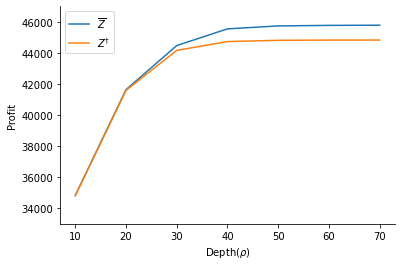

In [5]:
fig, ax = plt.subplots()
plt.plot(card, upper, label=r"$\overline{Z}$")
plt.plot(card, tmp, label=r"${Z}^{\dag}$")
plt.xlabel(r"Depth($\rho$)")
plt.ylabel("Profit")
plt.ylim([33000, 47000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.savefig("profit_depth.pdf")

In [49]:
upper = [36688, 39888, 43088, 45551, 46228, 46516, 46716]

In [50]:
tmp = [36661, 39836, 42079, 44734, 45862, 46349, 46662]

In [51]:
capa = [0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

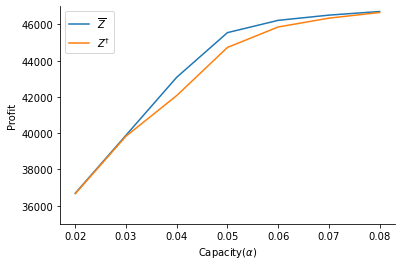

In [52]:
fig, ax = plt.subplots()
plt.plot(capa, upper, label=r"$\overline{Z}$")
plt.plot(capa, tmp, label=r"${Z}^{\dag}$")
plt.xlabel(r"Capacity($\alpha$)")
plt.ylabel("Profit")
plt.ylim([35000, 47000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.savefig("profit_capa.pdf")

In [53]:
upper = [45551, 45595, 45595, 45595, 45595]

In [54]:
tmp = [44734, 45332, 45337, 45341, 45342]

In [55]:
network = ["default", "+ 2-chain", "+ 3chain", "+ 4-chain", "+ 5-chain"]

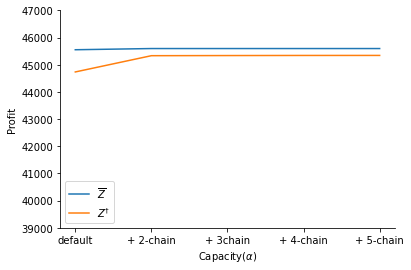

In [57]:
fig, ax = plt.subplots()
plt.plot(network, upper, label=r"$\overline{Z}$")
plt.plot(network, tmp, label=r"${Z}^{\dag}$")
plt.xlabel(r"Capacity($\alpha$)")
plt.ylabel("Profit")
plt.ylim([39000, 47000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend()
plt.savefig("profit_network.pdf")